# UW Data Challenge 2020
Group Name: Cappoo <br>
Members: Jasmine(Ching-Wen) Wang, Fiona(Meng-Chien) Lee, Brendan Thomas Zimmer

#### Goal: 
Analysis on variables influencing heart failure patient's death rate

#### Results:
Variables that correlates with death rate the most are ***'age','ejection_fraction', 'serum_creatinine', 'time'***, so we created a model using Random Forest and implemented grid search with cross validation for the best parameters. The **accuracy** improved from **78% to 89%**, and **false positive rate** decreased from **31.25% to 18.75%** compared to the untuned baseline model for all features.

** For more details, please refer to the report

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

In [5]:
df = pd.read_csv('train.csv')
df.head()

,Unnamed: 0,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,179,63.0,1,122,1,60,0,267000.0,1.2,145,1,0,147,0
1,14,50.0,1,168,0,38,1,276000.0,1.1,137,1,0,11,1
2,195,45.0,0,582,0,20,1,126000.0,1.6,135,1,0,180,1
3,118,85.0,1,102,0,60,0,507000.0,3.2,138,0,0,94,0
4,229,65.0,0,56,0,25,0,237000.0,5.0,130,0,0,207,0


In [6]:
df.shape

(270, 14)

# Clean Data
## Setup data dictionary 
* Check null (no null -> Missing_Values = 0)
* Check duplicate (no dup -> patient_index unique values = 270)
* data types

## Managing and Grouping
* separate quantitative and qualitative
* remove 1st column (patient index)


In [7]:
#set up data dict
datadict = pd.DataFrame()
datadict['data_type'] = df.dtypes
datadict['Missing Values'] = df.isnull().any()
datadict['Num_of_unique_values']  = df.nunique()
datadict

,data_type,Missing Values,Num_of_unique_values
Unnamed: 0,int64,False,270
age,float64,False,46
anaemia,int64,False,2
creatinine_phosphokinase,int64,False,193
diabetes,int64,False,2
ejection_fraction,int64,False,17
high_blood_pressure,int64,False,2
platelets,float64,False,169
serum_creatinine,float64,False,39
serum_sodium,int64,False,27


In [8]:
X = df.iloc[:, 1:13]
y = df['DEATH_EVENT']
df = df.iloc[:, 1:]

#quan and quali
q = datadict.index[datadict['Num_of_unique_values']==2]
qual = X[q[:-1]] # -1 => exclude death event
n = datadict.index[datadict['Num_of_unique_values']!=2]
quan = X[n[1:]] #1: => exclude patient index
qual.head()

,anaemia,diabetes,high_blood_pressure,sex,smoking
0,1,1,0,1,0
1,1,0,1,1,0
2,0,0,1,1,0
3,1,0,0,0,0
4,0,0,0,0,0


In [9]:
quan.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
0,63.0,122,60,267000.0,1.2,145,147
1,50.0,168,38,276000.0,1.1,137,11
2,45.0,582,20,126000.0,1.6,135,180
3,85.0,102,60,507000.0,3.2,138,94
4,65.0,56,25,237000.0,5.0,130,207


In [10]:
#outlier
print("Outliers: " , df[df < 0].sum().sum())
#range
df_range = pd.DataFrame(df.max()-df.min(), columns = ['range'])
df_range['min'] = df.min()
df_range['max'] = df.max()
df_range

Outliers:  0.0


,range,min,max
age,55.0,40.0,95.0
anaemia,1.0,0.0,1.0
creatinine_phosphokinase,7838.0,23.0,7861.0
diabetes,1.0,0.0,1.0
ejection_fraction,66.0,14.0,80.0
high_blood_pressure,1.0,0.0,1.0
platelets,824900.0,25100.0,850000.0
serum_creatinine,8.9,0.5,9.4
serum_sodium,35.0,113.0,148.0
sex,1.0,0.0,1.0


# Descriptive Statistics and Graphing

## Quantitative

In [11]:
quan.describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,60.639507,597.674074,38.240741,264016.054407,1.406889,136.670370,129.388889
std,11.754936,1007.037547,12.015379,97577.471257,1.074922,4.488591,77.380635
min,40.000000,23.000000,14.000000,25100.000000,0.500000,113.000000,4.000000
25%,51.000000,115.750000,30.000000,213500.000000,0.900000,134.000000,72.250000
50%,60.000000,251.500000,38.000000,263179.015000,1.100000,137.000000,114.000000
75%,69.750000,582.000000,45.000000,303750.000000,1.400000,140.000000,200.750000
max,95.000000,7861.000000,80.000000,850000.000000,9.400000,148.000000,280.000000


D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

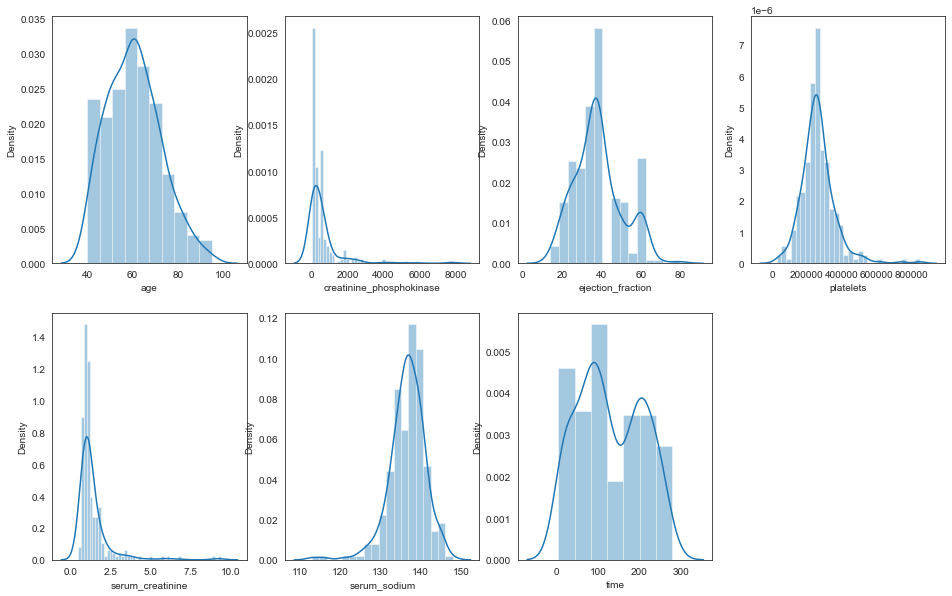

In [12]:
sns.set_style('white')
fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (16, 10))
for i, column in enumerate(quan.columns):
    sns.distplot(quan[column], ax=axes[i//4,i%4])
fig.delaxes(axes[1][3])

In [13]:
#checking if distribution is normally distributed -> decide whether to use ttest or mannwhitney
#p < 0.05 deviates from normal
from scipy.stats import shapiro
for i,c in enumerate(quan.columns):
    x = df[c]
    if shapiro(x)[1] > 0.05:
        print(c, ':\npvalue', shapiro(x)[1])
        print(c, "is normally distributed")
    else:
        print(c, ':\np-value: ', shapiro(x)[1])
        print(c, "is not normally distributed\n")

age :
p-value:  0.00023151759523898363
age is not normally distributed

creatinine_phosphokinase :
p-value:  1.2082259876355104e-26
creatinine_phosphokinase is not normally distributed

ejection_fraction :
p-value:  3.610980670032404e-08
ejection_fraction is not normally distributed

platelets :
p-value:  1.913384598331569e-12
platelets is not normally distributed

serum_creatinine :
p-value:  6.945121548804473e-26
serum_creatinine is not normally distributed

serum_sodium :
p-value:  1.227742463250081e-09
serum_sodium is not normally distributed

time :
p-value:  2.5747686649424395e-08
time is not normally distributed



## Categorical

In [14]:
for i, col in enumerate(qual.columns):
    if col != 'sex':
        print(col, ":\nno:", round(qual[col].value_counts(normalize = True)[0]*100,3), 
              "%    yes:", round(qual[col].value_counts(normalize= True)[1]*100,3), "%")
        print('count: ', "no:", round(qual[col].value_counts()[0]), 
              "    yes:", round(qual[col].value_counts()[1]), "\n")
    else:
        print(col, ":\nFemale:", round(qual[col].value_counts()[0]/270*100,3),
                "%    Male:", round(qual[col].value_counts()[1]/270*100,3))
        print('count: ', "Female:", round(qual[col].value_counts()[0]),
                "%    Male:", qual[col].value_counts()[1], "%\n")

anaemia :
no: 56.296 %    yes: 43.704 %
count:  no: 152     yes: 118 

diabetes :
no: 57.037 %    yes: 42.963 %
count:  no: 154     yes: 116 

high_blood_pressure :
no: 65.185 %    yes: 34.815 %
count:  no: 176     yes: 94 

sex :
Female: 33.704 %    Male: 66.296
count:  Female: 91 %    Male: 179 %

smoking :
no: 67.037 %    yes: 32.963 %
count:  no: 181     yes: 89 



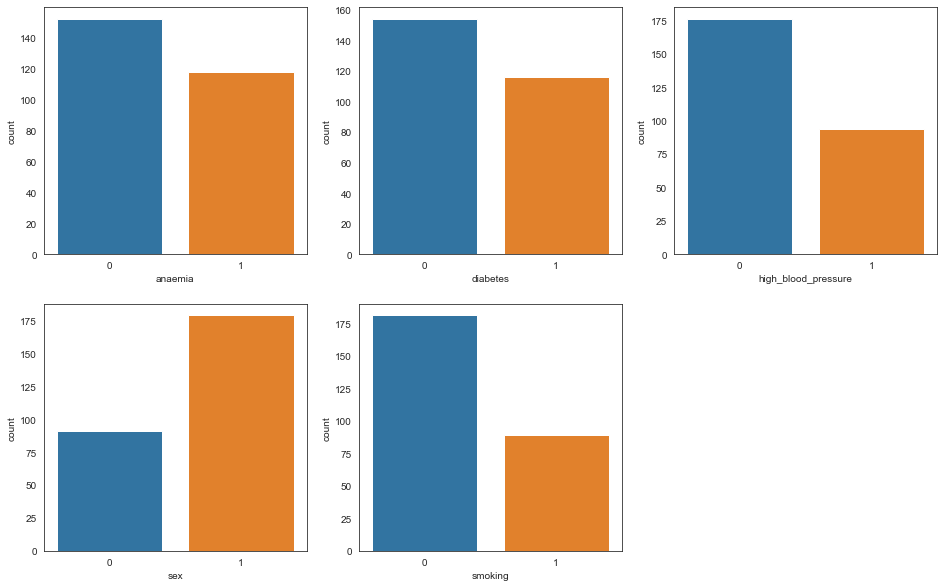

In [15]:
sns.set_style('white')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (16, 10))
for i, column in enumerate(qual.columns):
    sns.countplot(x = df[column], ax=axes[i//3,i%3])
fig.delaxes(axes[1][2])


## Target 
- Death Rate: 32.6%

In [16]:
df['DEATH_EVENT'].value_counts(normalize=True)

0    0.674074
1    0.325926
Name: DEATH_EVENT, dtype: float64

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DEATH_EVENT', ylabel='count'>

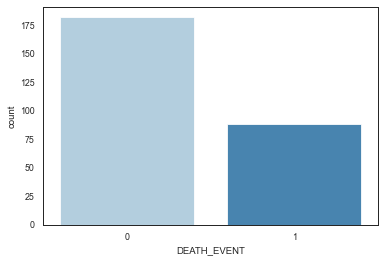

In [17]:
sns.set_context('paper')
sns.countplot(df["DEATH_EVENT"], palette = 'Blues')

Except for serum_creatinine and creatinine_phosphokinase, which are skewed, the other variables are symmetrically shaped. 


There are more male patients in this sample. 

# Bivariate Analysis
## Observing from the correlation, <br>people who died with heart failure on average have 
### Lower
- follow up period
- serum_sodium
- platelets
- ejection_fraction

### Higher
- creatinine_phosphokinase
- age
- serum_creatinine

### More susceptible to death if these are present/is
- anaemia
- high_blood_ pressure 
- smoking
- diabetes
- male patients

### Continuous and DEATH_EVENT

In [18]:
df.corr()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
age,1.000000,0.105771,-0.088564,-0.086414,0.076349,0.132891,-0.037921,0.161670,-0.049231,0.049769,0.032289,-0.220021,0.278624
anaemia,0.105771,1.000000,-0.185314,-0.055754,0.037725,-0.001277,-0.082324,0.062474,0.018160,-0.066812,-0.093658,-0.118125,0.056405
creatinine_phosphokinase,-0.088564,-0.185314,1.000000,0.004234,-0.044103,-0.079020,0.042440,-0.014770,0.062668,0.062588,-0.008418,-0.001204,0.064073
diabetes,-0.086414,-0.055754,0.004234,1.000000,-0.034265,-0.037461,0.077161,-0.044065,-0.104812,-0.140928,-0.131103,0.039996,0.003074
ejection_fraction,0.076349,0.037725,-0.044103,-0.034265,1.000000,0.022929,0.091527,-0.004633,0.186206,-0.156856,-0.084370,0.046487,-0.276842
high_blood_pressure,0.132891,-0.001277,-0.079020,-0.037461,0.022929,1.000000,0.061573,0.007119,0.043357,-0.071028,-0.016294,-0.150139,0.072368
platelets,-0.037921,-0.082324,0.042440,0.077161,0.091527,0.061573,1.000000,-0.045667,0.078544,-0.133816,0.047682,0.010763,-0.069381
serum_creatinine,0.161670,0.062474,-0.014770,-0.044065,-0.004633,0.007119,-0.045667,1.000000,-0.184712,-0.005646,-0.036226,-0.168866,0.299769
serum_sodium,-0.049231,0.018160,0.062668,-0.104812,0.186206,0.043357,0.078544,-0.184712,1.000000,-0.019231,-0.015234,0.102028,-0.172827
sex,0.049769,-0.066812,0.062588,-0.140928,-0.156856,-0.071028,-0.133816,-0.005646,-0.019231,1.000000,0.433305,-0.038306,0.011020


In [19]:
df.corr().iloc[-1,:]

age                         0.278624
anaemia                     0.056405
creatinine_phosphokinase    0.064073
diabetes                    0.003074
ejection_fraction          -0.276842
high_blood_pressure         0.072368
platelets                  -0.069381
serum_creatinine            0.299769
serum_sodium               -0.172827
sex                         0.011020
smoking                     0.016685
time                       -0.549912
DEATH_EVENT                 1.000000
Name: DEATH_EVENT, dtype: float64

In [20]:
# mean of features when death = 1 and 0 and their difference
p = pd.pivot_table(df, values = quan.columns, index = 'DEATH_EVENT')
diff = - p.iloc[0,:] + p.iloc[1,:]
p = p.append(diff, ignore_index  =True)
p.index = ['Survived','Died','Difference']
p

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
Survived,58.366302,552.890110,40.549451,268714.903407,1.183242,137.208791,158.923077
Died,65.340909,690.295455,33.465909,254297.980341,1.869432,135.556818,68.306818
Difference,6.974607,137.405345,-7.083541,-14416.923066,0.686190,-1.651973,-90.616259


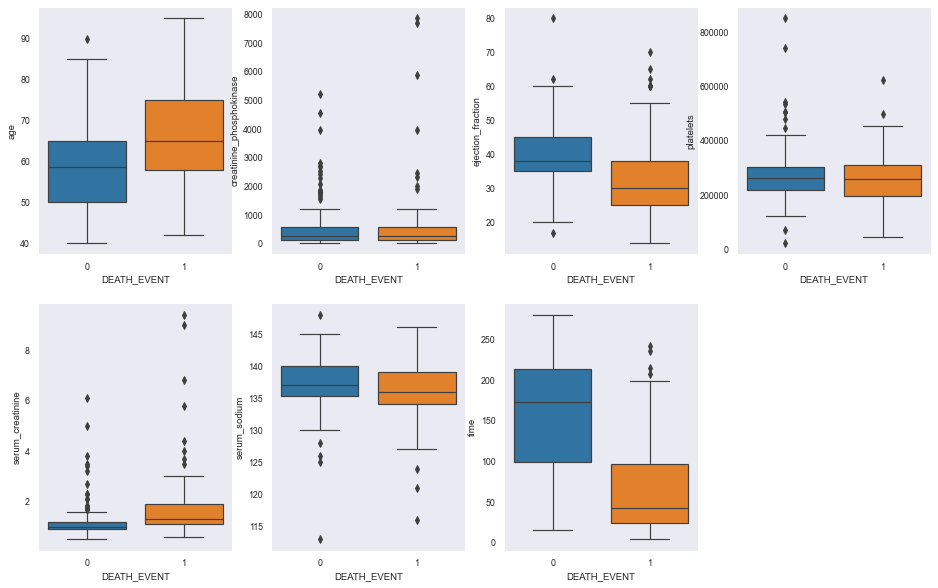

In [21]:
#visualize how quantiative variables change between death event = 0, 1
sns.set_style('dark')
fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (16, 10))
for i, column in enumerate(quan.columns):
    sns.boxplot(x =df['DEATH_EVENT'], y= df[column], ax=axes[i//4,i%4])
fig.delaxes(axes[1][3])

In [22]:
#mann whiteny test on continuous variables and death_event
#significantly related quantitative variables

for i,c in enumerate(quan.columns):
    x = df[df['DEATH_EVENT'] == 1][c]
    y = df[df['DEATH_EVENT'] == 0][c]
    if mannwhitneyu(x, y)[1] < 0.05:
        print(c, ": pvalue = ", mannwhitneyu(x, y)[1])

age : pvalue =  2.3071412313050553e-05
ejection_fraction : pvalue =  6.724266150037569e-07
serum_creatinine : pvalue =  1.4008542814448984e-10
serum_sodium : pvalue =  0.0010487072546045612
time : pvalue =  1.1975171038314945e-20


### Categoricla variables and DEATH_EVENT

In [23]:
for cat in qual.columns:
    a = pd.crosstab([df[cat]], df.DEATH_EVENT)
    dh = round(100*(a.iloc[0,:]/ a.sum(axis = 1)[0]).iloc[1,],2)
    h = round(100*(a.iloc[1,:]/a.sum(axis = 1)[1]).iloc[1,],2)
    print("Average Death Rate: ")
    if cat == 'sex':
        print("Female :", dh, "%")
        print("Male : ", h, "%")
    else:
        print("Don't have", cat, ": ",dh, "%")
        print("Have ", cat,": ", h, "%")
    print("Difference: ", round((h -dh),2),'%')
    print('\n')

no_risks= df.query('anaemia==0 and diabetes==0 and high_blood_pressure==0 and smoking==0')
nr = no_risks.DEATH_EVENT.value_counts()/39
print("Average Death Rate: \nNo risk: ", round(nr[1]*100,2),'%')

Average Death Rate: 
Don't have anaemia :  30.26 %
Have  anaemia :  35.59 %
Difference:  5.33 %


Average Death Rate: 
Don't have diabetes :  32.47 %
Have  diabetes :  32.76 %
Difference:  0.29 %


Average Death Rate: 
Don't have high_blood_pressure :  30.11 %
Have  high_blood_pressure :  37.23 %
Difference:  7.12 %


Average Death Rate: 
Female : 31.87 %
Male :  32.96 %
Difference:  1.09 %


Average Death Rate: 
Don't have smoking :  32.04 %
Have  smoking :  33.71 %
Difference:  1.67 %


Average Death Rate: 
No risk:  28.21 %


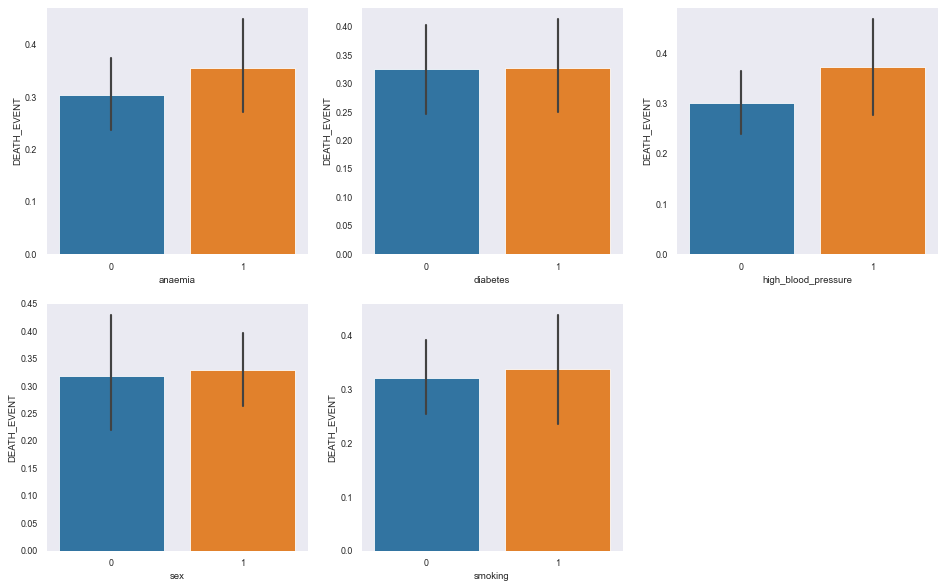

In [24]:
sns.set_context('paper')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (16, 10))
for i, column in enumerate(qual.columns):
    sns.barplot(x = df[column], y = df['DEATH_EVENT'], ax=axes[i//3,i%3])
plt.delaxes(axes[1,2])


D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'DEATH_EVENT')

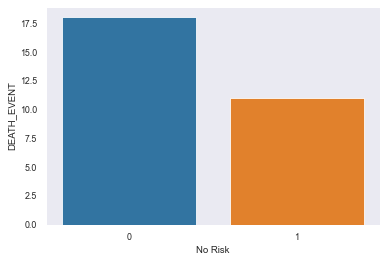

In [25]:
#no risk death_event counts
sns.countplot(no_risks['DEATH_EVENT'])
plt.xlabel("No Risk")
plt.ylabel('DEATH_EVENT')

In [26]:
#independence between qualitative variables and death_event
for i, col in enumerate(qual.columns):
    data = pd.crosstab([df[col]], df['DEATH_EVENT'])
    stat, p, dof, expected = chi2_contingency(data) 
    print(col, ' :', p)
    if p <0.05:
        print('Not Independent to DEATH_EVENT')
    else:
        print('Independent to DEATH_EVENT\n')

anaemia  : 0.4260617109091095
Independent to DEATH_EVENT

diabetes  : 0.9357366606796476
Independent to DEATH_EVENT

high_blood_pressure  : 0.2924070798484064
Independent to DEATH_EVENT

sex  : 0.9651078553863672
Independent to DEATH_EVENT

smoking  : 0.8917758955659659
Independent to DEATH_EVENT



# Multivariate Analysis
## Observations:
Interested variables --- 'age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time'
- observe relationship between them and quantitative variables
- observe these variables's relationship with qualitative variables


## Quan & Quan

In [27]:
cont = np.array(['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time'])

(6.0, -0.5)

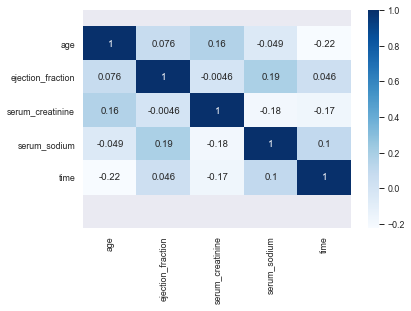

In [28]:
sns.set_context('paper')
ax = sns.heatmap(df[cont].corr(), annot = True, cmap = "Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 1 , top - 0.5)

In [29]:
from scipy.stats import pearsonr

cont_copy = quan.columns.copy()
for j in cont:
    for c in cont_copy:
        r = pearsonr(df[j],df[c])
        if j != c and r[1] < 0.05:
            print(j,' vs ', c, ' :', '\ncorrelation:', round(r[0],3), ', p-value: ', r[1], '\n')
    cont_copy = np.delete(cont_copy, np.argwhere(cont_copy == j))


age  vs  serum_creatinine  : 
correlation: 0.162 , p-value:  0.007774385793196841 

age  vs  time  : 
correlation: -0.22 , p-value:  0.00026918398831996107 

ejection_fraction  vs  serum_sodium  : 
correlation: 0.186 , p-value:  0.0021234955812733268 

serum_creatinine  vs  serum_sodium  : 
correlation: -0.185 , p-value:  0.002308961553707644 

serum_creatinine  vs  time  : 
correlation: -0.169 , p-value:  0.005404317935463078 



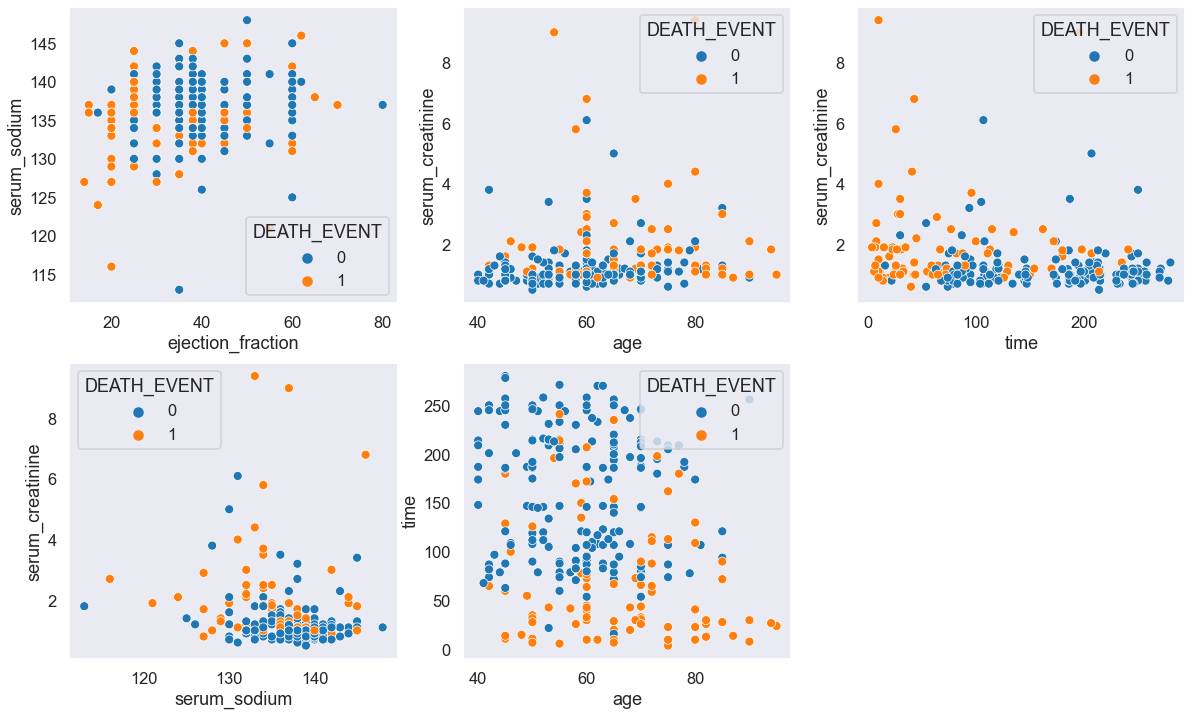

<Figure size 1440x1080 with 0 Axes>

In [30]:
sns.set_context('talk')
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,12))
plt.figure(figsize = (20,15))
sns.scatterplot(data = df, x = 'ejection_fraction', y = 'serum_sodium', hue = 'DEATH_EVENT',ax = axes[0][0])
sns.scatterplot(data = df, x = 'age', y = 'serum_creatinine', hue = 'DEATH_EVENT', ax = axes[0][1])
sns.scatterplot(data = df, x = 'time', y = 'serum_creatinine', hue = 'DEATH_EVENT', ax = axes[0][2])
sns.scatterplot(data = df, x = 'serum_sodium', y = 'serum_creatinine', hue = 'DEATH_EVENT', ax = axes[1][0])
sns.scatterplot(data = df, x = 'age', y = 'time', hue = 'DEATH_EVENT', ax = axes[1][1])
plt.delaxes(axes[1][2])

## Qualitative & Quantitative

In [31]:
#does median really significantly differs
from scipy.stats import mannwhitneyu
for j, q in enumerate(qual.columns):
    for i,c in enumerate(cont):
        x = df[df[q] == 1][c]
        y = df[df[q] == 0][c]
        if mannwhitneyu(x, y)[1] < 0.05:
            print(q, 'and', c, ": pvalue = ", mannwhitneyu(x, y)[1])
            print(f'test statistic: {mannwhitneyu(x, y)[0]}\n')

anaemia and time : pvalue =  0.03507178649187903
test statistic: 7815.0

high_blood_pressure and age : pvalue =  0.010474671657358103
test statistic: 6863.0

high_blood_pressure and time : pvalue =  0.006714571251938949
test statistic: 6760.5

sex and ejection_fraction : pvalue =  0.01081029811432541
test statistic: 6760.5



<AxesSubplot:xlabel='sex', ylabel='ejection_fraction'>

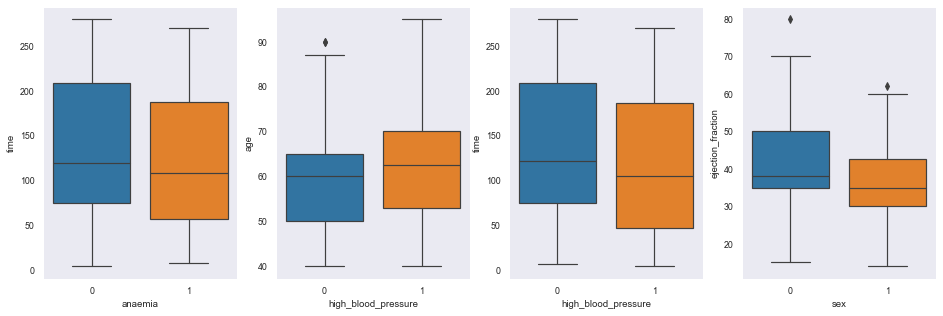

In [32]:
sns.set_context('paper')
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (16, 5))
sns.boxplot(x = df['anaemia'], y = df['time'], ax = axes[0])
sns.boxplot(x = df['high_blood_pressure'], y = df['age'],  ax = axes[1])
sns.boxplot(x = df['high_blood_pressure'], y = df['time'],ax = axes[2])
sns.boxplot(x = df['sex'], y = df['ejection_fraction'],ax = axes[3])

<AxesSubplot:xlabel='sex', ylabel='ejection_fraction'>

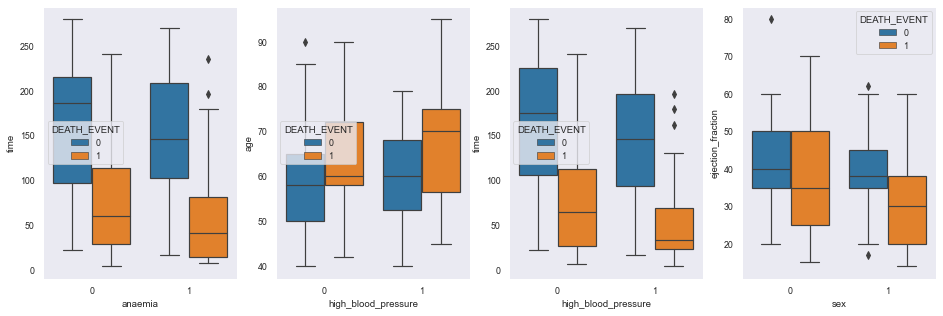

In [33]:
sns.set_context('paper')
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (16, 5))
sns.boxplot(x = df['anaemia'], y = df['time'], hue = df['DEATH_EVENT'], ax = axes[0])
sns.boxplot(x = df['high_blood_pressure'], y = df['age'], hue = df['DEATH_EVENT'], ax = axes[1])
sns.boxplot(x = df['high_blood_pressure'], y = df['time'], hue = df['DEATH_EVENT'], ax = axes[2])
sns.boxplot(x = df['sex'], y = df['ejection_fraction'], hue = df['DEATH_EVENT'], ax = axes[3])

## Qual & Qual

In [34]:
## none affected death significantly
qual_copy = np.hstack((qual.columns, 'DEATH_EVENT')).copy()

for i, coli in enumerate(np.hstack((qual.columns, 'DEATH_EVENT'))):
    for j, colj in enumerate(qual_copy):
        if coli != colj:
            data = pd.crosstab([df[coli]], df[colj])
            stat, p, dof, expected = chi2_contingency(data)
            if p < 0.05:
                print(coli, " vs ", colj, ": p value is " + str(p)) 
    qual_copy = np.delete(qual_copy, np.argwhere(qual_copy == coli))


diabetes  vs  sex : p value is 0.02884151854431723
diabetes  vs  smoking : p value is 0.04302475848939788
sex  vs  smoking : p value is 2.8896890294110463e-12


<AxesSubplot:xlabel='sex', ylabel='DEATH_EVENT'>

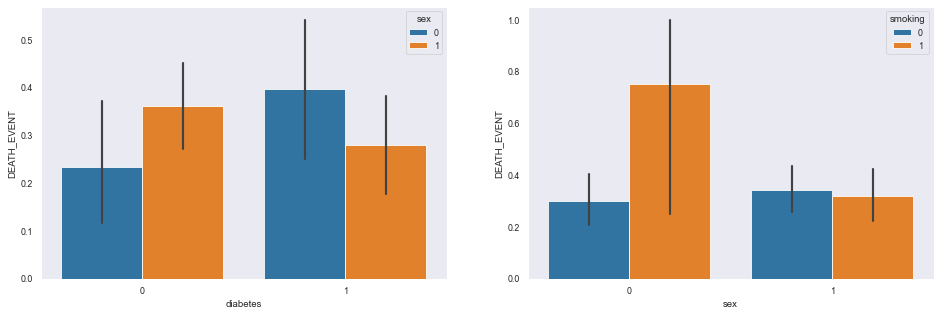

In [35]:
sns.set_context('paper')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (16, 5))
sns.barplot(x = df['diabetes'], hue = df['sex'], y = df['DEATH_EVENT'], ax = axes[0])
#sns.barplot(x = df['diabetes'], hue = df['smoking'], y = df['DEATH_EVENT'], ax=axes[2])
sns.barplot(x = df['sex'], hue = df['smoking'], y = df['DEATH_EVENT'], ax=axes[1])


# Fit model with All Features

In [89]:
y = df['DEATH_EVENT']
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
print(X.shape)
print(y.shape)

(270, 12)
(270,)


In [108]:
#All features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm,'\n')
print('Accuracy score:', accuracy_score(y_test, y_pred))
print('False positive:', cm[1,0])
print('False negative:', cm[0,1])
print('False Postive Rate: {}%'.format(100* cm[1,0]/(cm[1,0] + cm[1,1])))

[[33  5]
 [ 7  9]] 

Accuracy score: 0.7777777777777778
False positive: 7
False negative: 5
False Postive Rate: 43.75%


In [95]:
#All features: RandomizedSearchCV and results
# Create the parameter grid based on the results of random search 
param_grid = {
    'criterion': ['entropy','gini'],
    'max_depth': [10, 50, 100, 150, 200],
    'max_features': [2, 3],
    'n_estimators': [50, 100, 150, 200, 300, 400]
}

#classifier
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

#classifier
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
#                                n_iter = 100, cv = 3, verbose=2, random_state= 42, n_jobs = -1)
# Fit the random search model
# rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   16.5s finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [10, 50, 100, 150, 200],
                         'max_features': [2, 3],
                         'n_estimators': [50, 100, 150, 200, 300, 400]},
             verbose=2)

In [96]:
#bestParams
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 100, 'max_features': 2, 'n_estimators': 400}

In [107]:
#Display Results
classifier = RandomForestClassifier(n_estimators= 400, max_features = 2, criterion = 'gini', 
                                    max_depth =  100)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm,'\n')
print('Accuracy score:', accuracy_score(y_test, y_pred))
print('False positive:', cm[1,0])
print('False negative:', cm[0,1])
print('False Postive Rate: {}%'.format(100* cm[1,0]/(cm[1,0] + cm[1,1])))

[[35  3]
 [ 5 11]] 

Accuracy score: 0.8518518518518519
False positive: 5
False negative: 3
False Postive Rate: 31.25%


Selected Feature:
- Accuracy: Improved from 78% to 87%.
- False Positive Rate: improved from 43.75% to 31.25%

## Feature Selection

In [52]:
#Select Features using Random Forest Classifier
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
s = sel.get_support()
X.columns[s]

Index(['age', 'ejection_fraction', 'serum_creatinine', 'time'], dtype='object')

In [106]:
#define new train test
y = df['DEATH_EVENT']
X_2 = X[X.columns[s]]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y, test_size=0.20, random_state=42)

#fit selected features 
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train_2, y_train_2)


y_pred_2 = classifier.predict(X_test_2)
cm = confusion_matrix(y_test_2, y_pred_2)
print(cm,'\n')
print('Accuracy score:', accuracy_score(y_test_2, y_pred_2))
print('False positive:', cm[1,0])
print('False negative:', cm[0,1])
print('False Postive Rate: {}%'.format(100* cm[1,0]/(cm[1,0] + cm[1,1])))

[[36  2]
 [ 5 11]] 

Accuracy score: 0.8703703703703703
False positive: 5
False negative: 2
False Postive Rate: 31.25%


In [97]:
#refit with selected features and RandomSearchCV
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train_2, y_train_2)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   16.3s finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [10, 50, 100, 150, 200],
                         'max_features': [2, 3],
                         'n_estimators': [50, 100, 150, 200, 300, 400]},
             verbose=2)

In [98]:
#bestParams
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 2,
 'n_estimators': 100}

In [105]:
#Display Results
classifier = RandomForestClassifier(n_estimators= 100, max_features = 2, criterion = 'entropy',
                                    max_depth =  10)
classifier.fit(X_train_2, y_train_2)
y_pred_2 = classifier.predict(X_test_2)
cm = confusion_matrix(y_test_2, y_pred_2)
print(cm,'\n')
print('Accuracy score:', accuracy_score(y_test_2, y_pred_2))
print('False positive:', cm[1,0])
print('False negative:', cm[0,1])
print('False Postive Rate: {}%'.format(100* cm[1,0]/(cm[1,0] + cm[1,1])))

[[35  3]
 [ 3 13]] 

Accuracy score: 0.8888888888888888
False positive: 3
False negative: 3
False Postive Rate: 18.75%


Selected Feature:
- Accuracy: Improved from 87% to 89%.
- False Positive Rate: improved from 31.25% to 18.75%

# Results:
Going from baseline model of all features to selected features using GridSearchCV, accuracy improved from 78% to 89%, and False Positive Rate decreased from 31.25% to 18.75%.